# Trading strategy on real data only

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from scipy.stats import chi2


In [18]:
# === Load data ===
returns = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)
regimes = pd.read_csv('data/regimes.csv', index_col=0, parse_dates=True)['Regime']
#returns = df.pct_change().dropna()

In [19]:
# === Split into train/test ===
split_idx = int(len(returns) * 0.7)
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]
test_regimes = regimes.loc[test_returns.index]

### Cross-Sectional Momentum Trading Strategy 

1. **Lagged Return Ranking**
   - For each day `t`, compute asset returns from **day `t-1`**.
   - Rank all assets **cross-sectionally** based on these lagged returns (within the same day).

2. **Signal Generation**
   - Go **long** (buy) the top `long_quantile` fraction of assets (e.g., top 20%).
   - Go **short** (sell) the bottom `short_quantile` fraction of assets (e.g., bottom 20%).

3. **Portfolio Construction**
   - Assign **equal weights** within each selected group (long and short).
   - Ensure the portfolio is **dollar-neutral**, meaning the total long and short exposures are balanced.
   - **Rebalance daily** based on updated ranks.


In [20]:
def two_quantile_strategy(returns, long_quantile=0.2, short_quantile=0.2):
    """
    Cross-sectional momentum strategy:
    - Long top 'long_quantile' fraction of assets (e.g., top 20%)
    - Short bottom 'short_quantile' fraction of assets (e.g., bottom 20%)
    """
    # Use lagged returns to rank assets (to avoid lookahead bias)
    lagged = returns.shift(1)
    ranks = lagged.rank(axis=1, pct=True)  # percentiles row-wise

    # Define long and short positions
    long_mask = (ranks >= 1 - long_quantile).astype(int)
    short_mask = (ranks <= short_quantile).astype(int) * -1

    # Combine positions
    weights = long_mask + short_mask

    # Normalize weights (ensure sum of abs weights per day is 1)
    weights = weights.div(weights.abs().sum(axis=1), axis=0).fillna(0)

    # Compute daily strategy returns
    strat_returns = (weights * returns).sum(axis=1)
    return strat_returns


### Parameters

- **`long_quantile`**: fraction of top-performing assets to go long on (e.g., 0.1 to 0.3).
- **`short_quantile`**: fraction of bottom-performing assets to go short on (e.g., 0.1 to 0.3).

These two hyperparameters are calibrated jointly to maximize the **Sharpe ratio** on the training set.


In [21]:
# === Calibration metric ===
def sharpe_ratio(r):
    return r.mean() / r.std() * np.sqrt(252)

# === Grid search on train set ===
param_grid = {
    'long_quantile': np.arange(0.01, 0.3, 0.05),
    'short_quantile': np.arange(0.01, 0.3, 0.05)
}
results = []

for params in ParameterGrid(param_grid):
    r = two_quantile_strategy(train_returns, **params)
    s = sharpe_ratio(r)
    results.append((params['long_quantile'], params['short_quantile'], s))

results_df = pd.DataFrame(results, columns=['long_quantile', 'short_quantile', 'Sharpe'])
best_params = results_df.sort_values(by='Sharpe', ascending=False).iloc[0][['long_quantile', 'short_quantile']]


In [22]:
best_params

long_quantile     0.16
short_quantile    0.06
Name: 19, dtype: float64

### Evaluation Approach

- **Train/test split**: we calibrate `long_quantile` and `short_quantile` on 70% of the real data  
- **Backtest**: evaluate out-of-sample performance on the remaining 30%  
- **Regime-based analysis**: assess how the strategy performs under Bull, Bear, and Risky market conditions

Performance is measured using:

- **Sharpe ratio**  
- **Cumulative return**  
- **Max drawdown**  
- **Regime-wise statistics**


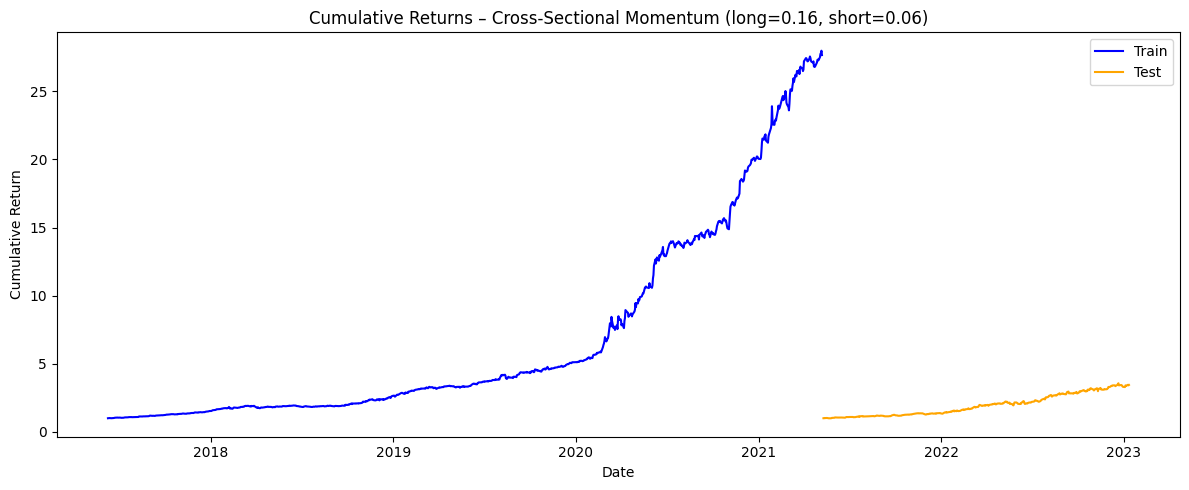

In [23]:
# === Train & test strategy using best quantiles ===
train_strategy = two_quantile_strategy(train_returns, **best_params)
test_strategy  = two_quantile_strategy(test_returns, **best_params)

# === Cumulative return plot ===
cum_train = (1 + train_strategy).cumprod()
cum_test  = (1 + test_strategy).cumprod()

long_q = best_params['long_quantile']
short_q = best_params['short_quantile']

plt.figure(figsize=(12,5))
plt.plot(cum_train, label='Train', color='blue')
plt.plot(cum_test,  label='Test',  color='orange')
plt.title(f"Cumulative Returns – Cross-Sectional Momentum (long={long_q:.2f}, short={short_q:.2f})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
# === Global performance metrics ===
def performance_metrics(r):
    cum = (1 + r).cumprod()
    dd = cum / cum.cummax() - 1
    return pd.Series({
        'Annual Return': r.mean() * 252,
        'Annual Volatility': r.std() * np.sqrt(252),
        'Sharpe Ratio': sharpe_ratio(r),
        'Max Drawdown': dd.min()
    }).round(4)

print("=== Overall Test Performance ===")
print(performance_metrics(test_strategy))

# === Regime-wise evaluation ===
def regime_perf(r, regimes):
    df = pd.DataFrame({'r': r, 'Regime': regimes})
    grouped = df.groupby('Regime')['r'].agg(['mean','std','count'])
    grouped['Sharpe'] = grouped['mean'] / grouped['std'] * np.sqrt(252)
    return grouped.round(4)

print("\n=== Regime-wise Sharpe (Test Set) ===")
print(regime_perf(test_strategy, test_regimes))


=== Overall Test Performance ===
Annual Return        0.7697
Annual Volatility    0.2546
Sharpe Ratio         3.0237
Max Drawdown        -0.1273
dtype: float64

=== Regime-wise Sharpe (Test Set) ===
          mean    std  count  Sharpe
Regime                              
Risky   0.0031  0.016    423  3.0237


# Trading strategy on real data + augmented data in training

In [25]:
# === Load data ===
returns_aug = pd.read_csv("data/returns_augmented.csv", index_col=0, parse_dates=True)

In [26]:
# === Define real-only boundaries ===
real_returns = pd.read_csv("data/returns.csv", index_col=0, parse_dates=True)
real_index = real_returns.index
split_idx = int(len(real_index) * 0.7)

train_real_idx = real_index[:split_idx]
test_real_idx  = real_index[split_idx:]

# === Rebuild train and test ===
train_returns_aug = returns_aug.loc[~returns_aug.index.isin(test_real_idx)]  # includes real+synthetic
test_returns_real = returns_aug.loc[test_real_idx]                           # test remains real

test_regimes      = regimes.loc[test_real_idx]


In [27]:
# === Grid search calibration on extended training set ===
results_aug = []

for params in ParameterGrid(param_grid):
    r = two_quantile_strategy(train_returns_aug, **params)
    s = sharpe_ratio(r)
    results_aug.append((params['long_quantile'], params['short_quantile'], s))

results_df_aug = pd.DataFrame(results_aug, columns=['long_quantile', 'short_quantile', 'Sharpe'])
best_params_aug = results_df_aug.sort_values(by='Sharpe', ascending=False).iloc[0][['long_quantile', 'short_quantile']]


In [28]:
best_params_aug

long_quantile     0.26
short_quantile    0.16
Name: 33, dtype: float64

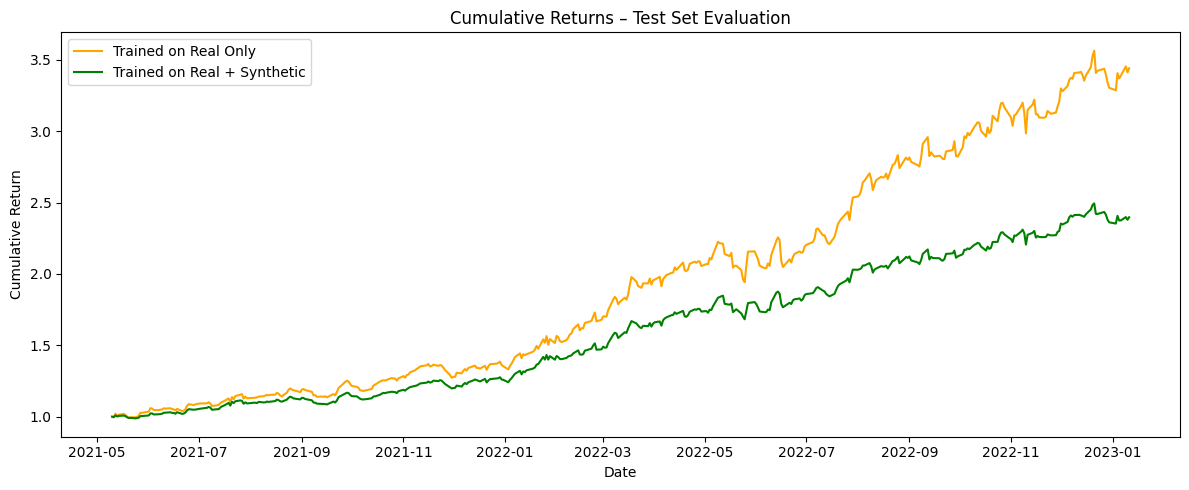

In [29]:
# === Evaluate on the same test set as before ===
test_strategy_aug = two_quantile_strategy(test_returns_real, **best_params_aug)

# === Plot cumulative returns ===
cum_test_aug = (1 + test_strategy_aug).cumprod()

plt.figure(figsize=(12,5))
plt.plot(cum_test,     label='Trained on Real Only', color='orange')
plt.plot(cum_test_aug, label='Trained on Real + Synthetic', color='green')
plt.title("Cumulative Returns – Test Set Evaluation")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
print("=== Performance on Test Set (Trained on Real + Synthetic) ===")
print(performance_metrics(test_strategy_aug))
print("\n=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===")
print(regime_perf(test_strategy_aug, test_regimes))

=== Performance on Test Set (Trained on Real + Synthetic) ===
Annual Return        0.5373
Annual Volatility    0.1780
Sharpe Ratio         3.0178
Max Drawdown        -0.0894
dtype: float64

=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===
          mean     std  count  Sharpe
Regime                               
Risky   0.0021  0.0112    423  3.0178


## Impact of Synthetic Data on Strategy Calibration

We compared the performance of a cross-sectional momentum strategy trained on two datasets:

- **Real data only** (70% of the original time period)
- **Real data augmented with synthetic returns** (via VAE)

Both strategies were evaluated on the **same real out-of-sample test set**, allowing a fair and controlled comparison.

### Overall Performance

The strategy trained on real data only achieved a slightly higher Sharpe ratio (**3.02 vs. 3.01**) and significantly higher annual return (**76.97% vs. 53.73%**). However, the augmented version offered better downside protection, with a **lower max drawdown** (**-8.94% vs. -12.73%**).

This suggests that while the real-only model captured more profitable signals, the augmented strategy was more conservative and resilient to large losses.

### Regime-Wise Analysis

In the Risky regime, both models achieved nearly identical Sharpe ratios (~3.02), suggesting consistent performance in volatile conditions. However, there is **no observed benefit from synthetic augmentation** in regime-specific behavior, as the regime-wise mean and volatility were both slightly lower for the augmented model.

### Conclusion

In this experiment, augmenting with synthetic data slightly **reduced performance** in terms of return and Sharpe ratio, but it **improved risk control** by reducing drawdown. These results suggest a trade-off: synthetic data may act as a regularizer that sacrifices some upside in exchange for greater stability.


# Risk evaluation (1-months α-VaR) with real data only 

In [31]:
def compute_historical_var(returns, alpha=0.99, horizon=21, window=252):
    """
    Estimate 1-month ahead historical VaR using a rolling window.
    """
    # Daily historical VaR scaled to 1-month horizon
    var = returns.rolling(window).apply(lambda x: np.percentile(x, (1 - alpha) * 100))
    return var.shift(1) * np.sqrt(horizon)  # one-step-ahead prediction


def compute_realized_horizon_returns(returns, horizon=21):
    """
    Compute realized cumulative return over the forward horizon (e.g., 21-day forward return).
    """
    return returns.rolling(horizon).sum().shift(-horizon + 1)


In [32]:
def kupiec_test(n, x, alpha):
    """
    Kupiec's unconditional coverage test.
    n = total forecasts
    x = number of VaR exceedances
    alpha = 1 - confidence level (e.g., 0.01 for 99%)
    """
    p_hat = x / n
    LR = -2 * (
        np.log((1 - alpha) ** (n - x) * alpha ** x) -
        np.log((1 - p_hat) ** (n - x) * p_hat ** x)
    )
    p_value = 1 - chi2.cdf(LR, df=1)
    return {"LR": LR, "p-value": p_value, "observed_rate": p_hat}


In [33]:
def evaluate_var_forecast(returns, alpha=0.99, horizon=21, label=""):
    """
    Run the full VaR evaluation pipeline.
    """
    # Step 1: Compute forecasts
    var = compute_historical_var(returns, alpha, horizon)
    realized = compute_realized_horizon_returns(returns, horizon)

    # Step 2: Align and filter valid entries
    valid_idx = ~var.isna() & ~realized.isna()
    var = var[valid_idx]
    realized = realized[valid_idx]

    # Step 3: Check exceedances
    exceed = realized < var
    exceedance_rate = exceed.mean()

    # Step 4: Kupiec test
    test_result = kupiec_test(len(exceed), exceed.sum(), 1 - alpha)

    # Step 5: Print and plot
    print(f"\n=== {label} ===")
    print(f"Exceedance rate: {exceedance_rate:.4f}")
    print("Kupiec Test:", test_result)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(realized.index, realized, label='Realized Return (1-month)')
    plt.plot(var.index, var, label=f'{int(alpha*100)}% 1-Month VaR', color='red')
    plt.fill_between(realized.index, realized, var, where=exceed, color='red', alpha=0.2, label='Exceedance')
    plt.title(f'{int(alpha*100)}% 1-Month VaR Forecast – {label}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Trained on Real Only ===
Exceedance rate: 0.0000
Kupiec Test: {'LR': 3.0352014277574377, 'p-value': 0.08147643661941584, 'observed_rate': 0.0}


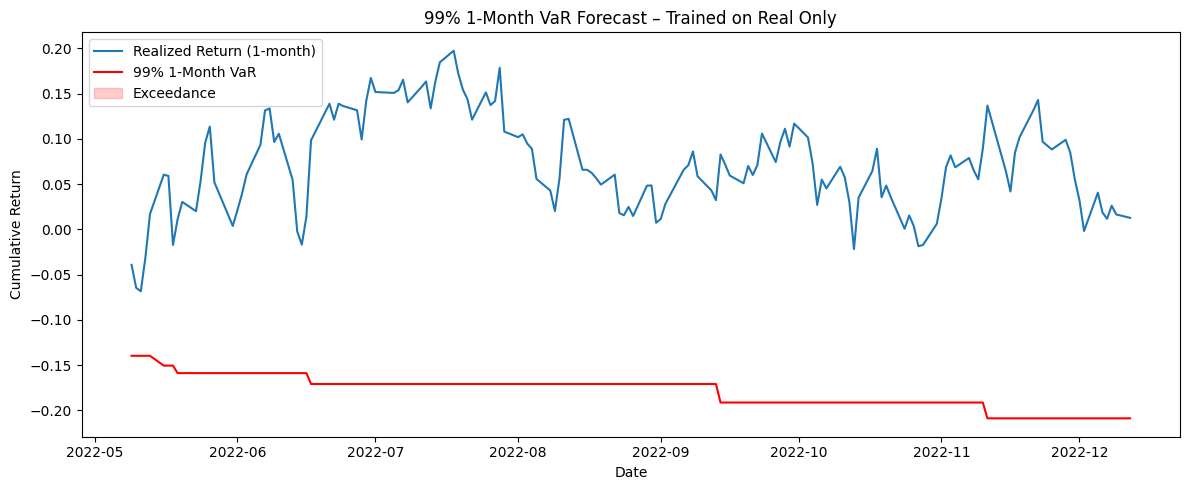

In [34]:
evaluate_var_forecast(test_strategy, alpha=0.99, horizon=21, label="Trained on Real Only")

# Risk evaluation (1-months α-VaR) with real + augmented data in training


=== Trained on Real + Synthetic ===
Exceedance rate: 0.0000
Kupiec Test: {'LR': 15.490574905040276, 'p-value': 8.291767180768073e-05, 'observed_rate': 0.0}


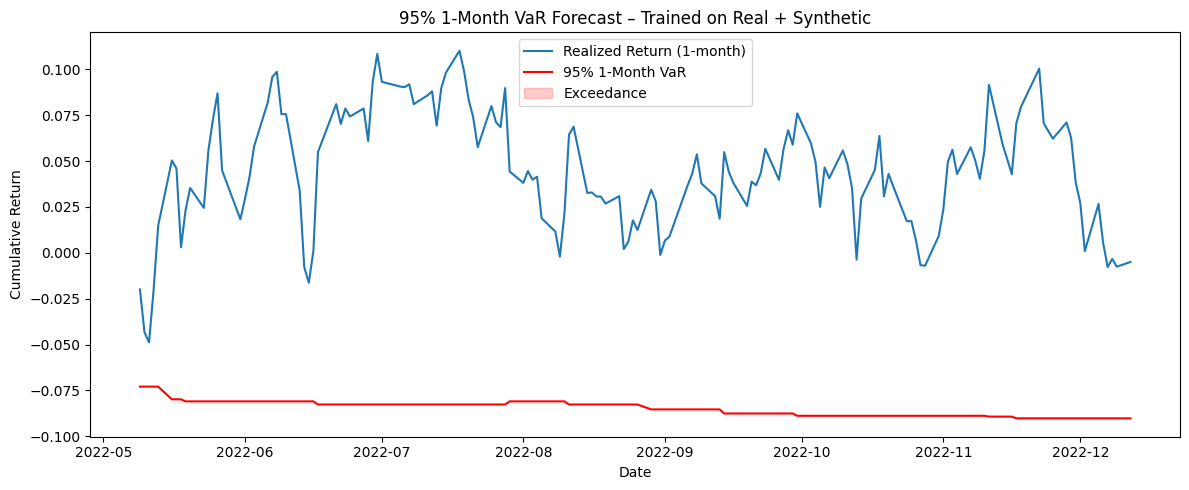

In [36]:
evaluate_var_forecast(test_strategy_aug, alpha=0.95, horizon=21, label="Trained on Real + Synthetic")